In [101]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/edited_rating.csv")

N = df.userId.max() + 1 #Number of users
M = df.movie_index.max() + 1 #Number of movies

#Shuffling the data
df = shuffle(df)

#Init dicts 
user_to_movie = {}
movie_to_user = {}
user_and_movie_to_rating = {}

#updating dictionaries
def update_dicts(row):
    i = int(row.userId)
    j = int(row.movie_index)

    if i not in user_to_movie:
        user_to_movie[i] = [j]
    else:
        user_to_movie[i].append(j)

    if j not in movie_to_user:
        movie_to_user[j] = [i]
    else:
        movie_to_user[j].append(i)

    user_and_movie_to_rating[(i,j)] = row.rating

df.apply(update_dicts, axis=1)

52951    None
14160    None
26252    None
53316    None
94506    None
         ... 
95926    None
81398    None
30044    None
92044    None
91153    None
Length: 100836, dtype: object

In [5]:
def cosine_similarity(user1, user2):
    numerator = np.dot(user1, user2) #Dot product of the two users' ratings
    denominator = np.linalg.norm(user1) * np.linalg.norm(user2) #Multiplying the norms of the ratings
    cosine_similarity = numerator / denominator

    return cosine_similarity

In [110]:
def mean_squared_diff_similarity(user1, user2):
    msd_dist = np.mean((user1 - user2)**2) # Mean of the squared differences of the two users' ratings
    msd_similarity = 1 / (msd_dist + 1) #Calculating the MSD similarity

    return msd_similarity

In [84]:
def pearson_similarity(user1 , user2):
    #Means of users' ratings
    user1_mean = np.mean(user1)
    user2_mean = np.mean(user2)

    #Applying the pearson similarity formula
    numerator = np.sum((user1 - user1_mean) * (user2 - user2_mean))
    denominator = np.sqrt(np.sum((user1 - user1_mean)**2)) * np.sqrt(np.sum((user2 - user2_mean)**2))

    if denominator == 0:
        return 0.5 #Returning a neutral value if the denominator is 0 to prevent division by 0

    return numerator / denominator

In [99]:
def knn(k, user_id, user_to_movie, user_and_movie_to_rating, similarity_type):
    users_similarities = [] #Initializing a list to store similar users' ids and the similarity
    
    for other_user_id in range(N): #Iterating over all the users to find similar users to the user sent
        if other_user_id != user_id:
            common_movies = np.intersect1d(user_to_movie[user_id], user_to_movie[other_user_id]) #Movies that are rated by both users

            if len(common_movies) > 2: #Calculating similarities only if the two users have at least 3 co-rated movies
                #Both users' ratings for co-rated movies
                user_ratings = np.array([user_and_movie_to_rating[(user_id, movie)] for movie in common_movies])
                other_user_ratings = np.array([user_and_movie_to_rating[(other_user_id, movie)] for movie in common_movies])

                similarity = similarity_type(user_ratings, other_user_ratings) #Using the input similarity function
                users_similarities.append((other_user_id, similarity)) #Storing similar user's id and the similarity value

    sorted_users_similarities = sorted(users_similarities, key=lambda x: x[1], reverse=True)
    return sorted_users_similarities[:k] #Returning the k-most similar users

In [104]:
def knn_basic(user_id, users_similarities, user_to_movie, user_and_movie_to_rating):
    predictions = np.zeros(len(user_to_movie[user_id]))

    for movie_index in range(len(predictions)):
        weighted_sum = 0
        similarity_sum = 0
        #Predicting the user's ratings according to KNN-Basic formula
        for similar_user_id, similarity in users_similarities:
            if movie_index in user_to_movie[similar_user_id]: #Only predicting the movies that are actually rated by the user in the original dataset for evaluation
                similar_user_rating = user_and_movie_to_rating[(similar_user_id, movie_index)]
                weighted_sum += (similarity * similar_user_rating)
                similarity_sum += similarity
        if similarity_sum == 0:
            predictions[movie_index] = 0 #To prevent division by zero
        else:
            predictions[movie_index] = weighted_sum / similarity_sum

    return predictions

In [117]:
def knn_mean(user_id, users_similarities, user_to_movie, user_and_movie_to_rating):
    predictions = np.zeros(len(user_to_movie[user_id]))
    
    user_ratings_mean = np.mean([user_and_movie_to_rating[user_id, movie] for movie in user_to_movie[user_id]])
    
    for movie_index in range(len(predictions)):
        weighted_sum = 0
        similarity_sum = 0
        #Predicting the user's ratings according to KNN with Means formula
        for similar_user_id, similarity in users_similarities:
            if movie_index in user_to_movie[similar_user_id]:
                similar_user_rating = user_and_movie_to_rating[(similar_user_id, movie_index)]
                similar_user_ratings_mean = np.mean([user_and_movie_to_rating[similar_user_id, movie] for movie in user_to_movie[similar_user_id]])
                weighted_sum += similarity * (similar_user_rating - similar_user_ratings_mean)
                similarity_sum += similarity
        if similarity_sum == 0:
            predictions[movie_index] = 0
        else:
            predictions[movie_index] = user_ratings_mean + (weighted_sum / similarity_sum)
    
    return predictions

In [118]:
def knn_zscore(user_id, users_similarities, user_to_movie, user_and_movie_to_rating):
    predictions = np.zeros(len(user_to_movie[user_id]))
    
    user_ratings_mean = np.mean([user_and_movie_to_rating[user_id, movie] for movie in user_to_movie[user_id]])
    user_ratings_std = np.std([user_and_movie_to_rating[user_id, movie] for movie in user_to_movie[user_id]])
    
    for movie_index in range(len(predictions)):
        weighted_sum = 0
        similarity_sum = 0
        #Predicting the user's ratings according to KNN with Z-score formula
        for similar_user_id, similarity in users_similarities:
            if movie_index in user_to_movie[similar_user_id]:
                similar_user_rating = user_and_movie_to_rating[(similar_user_id, movie_index)]
                similar_user_ratings_mean = np.mean([user_and_movie_to_rating[similar_user_id, movie] for movie in user_to_movie[similar_user_id]])
                similar_user_ratings_std = np.std([user_and_movie_to_rating[similar_user_id, movie] for movie in user_to_movie[similar_user_id]])

                if similar_user_ratings_std != 0:
                    similar_user_z_score = (similar_user_rating - similar_user_ratings_mean) / similar_user_ratings_std
                else:
                    similar_user_z_score = 0
                
                weighted_sum += similarity * similar_user_z_score
                similarity_sum += similarity
        if similarity_sum == 0:
            predictions[movie_index] = 0
        else:
            predictions[movie_index] = user_ratings_mean + user_ratings_std * (weighted_sum / similarity_sum)
    
    return predictions

In [98]:
def calculate_all_predictions(user_to_movie, user_and_movie_to_rating, knn_method, similarity_type, k):
    num_users = N

    all_user_predictions = {}

    for user_id in range(num_users): #Iterating over all users
        users_similarities = knn(k, user_id, user_to_movie, user_and_movie_to_rating, similarity_type) #Finding k-most similar users to the current user
        predictions = knn_method(user_id, users_similarities, user_to_movie, user_and_movie_to_rating) #Predicted ratings of the current user
        all_user_predictions[user_id] = predictions
    
    return all_user_predictions

In [67]:
def overall_mae(all_user_predictions, user_to_movie, user_and_movie_to_rating):
    num_users = N
    overall_mae = 0

    #Calculating the mean absolute error for the entire dataset
    for user_id in range(num_users):
        predicted_ratings = all_user_predictions[user_id]
        actual_ratings = [user_and_movie_to_rating[(user_id, movie_index)] for movie_index in user_to_movie[user_id]]

        user_mae = np.mean(np.abs(np.array(predicted_ratings) - np.array(actual_ratings)))

        overall_mae += user_mae
    
    overall_mae /= num_users

    return overall_mae

In [122]:
def overall_rmse(all_user_predictions, user_to_movie, user_and_movie_to_rating):
    num_users = N
    overall_rmse = 0

    #Calculating the mean squared error for the entire dataset
    for user_id in range(num_users):
        predicted_ratings = all_user_predictions[user_id]
        actual_ratings = [user_and_movie_to_rating[(user_id, movie_index)] for movie_index in user_to_movie[user_id]]

        user_rmse = np.sqrt(np.mean((np.array(predicted_ratings) - np.array(actual_ratings))**2))

        overall_rmse += user_rmse
    
    overall_rmse /= num_users

    return overall_rmse

In [132]:
similarity_types = [cosine_similarity, mean_squared_diff_similarity, pearson_similarity]
knn_methods = [knn_basic, knn_mean, knn_zscore]
k_values = [40, 60, 80]

In [133]:
def plot_errors(ax, knn_method, similarity_type, mae_list, rmse_list):
    ax.plot(k_values, mae_list, label="MAE")
    ax.plot(k_values, rmse_list, label="RMSE", color='orange')
    ax.set_title(f"{knn_method.__name__}, {similarity_type.__name__}")
    ax.set_xlabel("k Values")
    ax.set_ylabel("Errors")
    ax.legend()

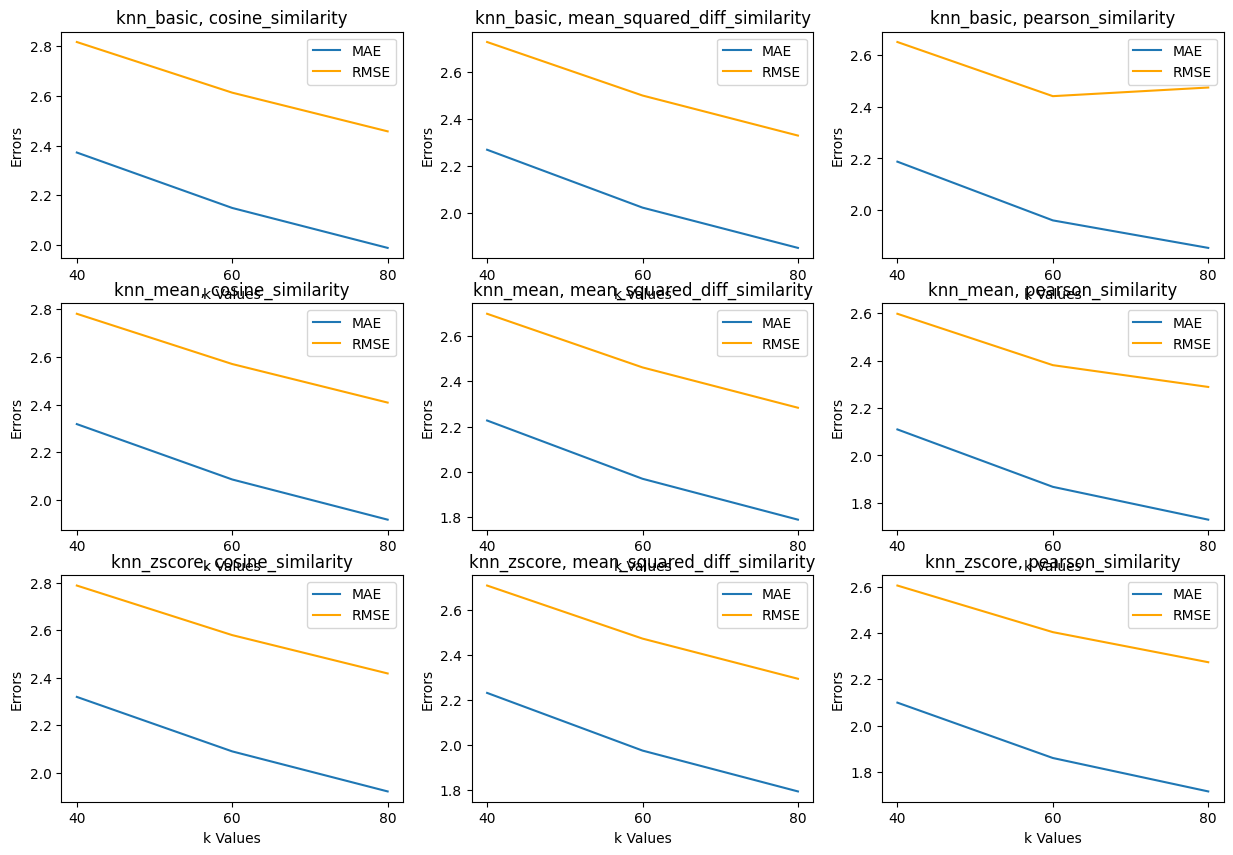

In [134]:
fig, axs = plt.subplots(len(knn_methods), len(similarity_types), figsize=(15, 10))

for i, knn_method in enumerate(knn_methods):
    for j, similarity_type in enumerate(similarity_types):
        mae_list = []
        rmse_list = []
        for k in k_values:
            all_user_predictions = calculate_all_predictions(user_to_movie, user_and_movie_to_rating, knn_method, similarity_type, k)
            mae = overall_mae(all_user_predictions, user_to_movie, user_and_movie_to_rating)
            mae_list.append(mae)
            rmse = overall_rmse(all_user_predictions, user_to_movie, user_and_movie_to_rating)
            rmse_list.append(rmse)
        plot_errors(axs[i, j], knn_method, similarity_type, mae_list, rmse_list)
        axs[i, j].set_xticks(k_values)

According to the error plots above, the best performing KNN method is KNN with Z-score, the best best performing similarity measure is Pearson similarity and the k value that gives the lowest errors is 80.

In [138]:
all_user_predictions = calculate_all_predictions(user_to_movie, user_and_movie_to_rating, knn_zscore, pearson_similarity, 80)
mae = overall_mae(all_user_predictions, user_to_movie, user_and_movie_to_rating)
rmse = overall_rmse(all_user_predictions, user_to_movie, user_and_movie_to_rating)
print("MAE: ", mae)
print("RMSE: ", rmse)

MAE:  1.7171892238588897
RMSE:  2.2739522719574574
